In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f3d9f02247647d7a7d0a6cab8b46c8c7a495c653f33137dea1bda84c2e37c457
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Dataset shape: (16599, 19)
Tras LOF -> filas: 15769
Usando 300 muestras para entrenamiento/prueba.
Train / Test shapes: (240, 8) (60, 8)

Entrenando modelo VQR — esto puede tardar unos minutos...

VQR -> MSE: 4.400363e-04, MAE: 1.672518e-02
⚠️ No se registraron pérdidas en el callback (SPSA no devuelve loss).


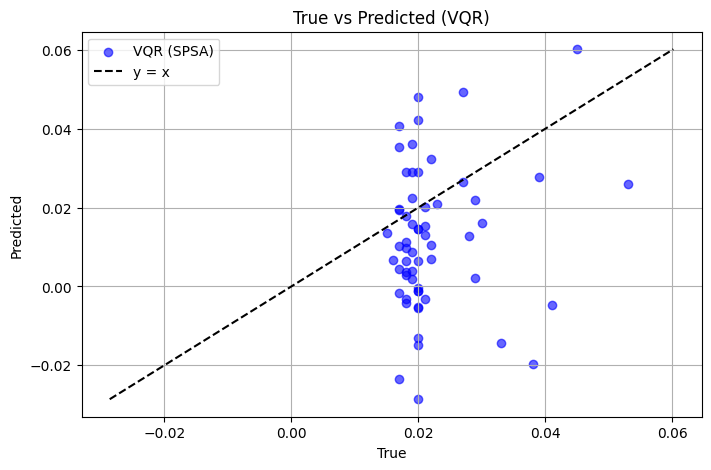

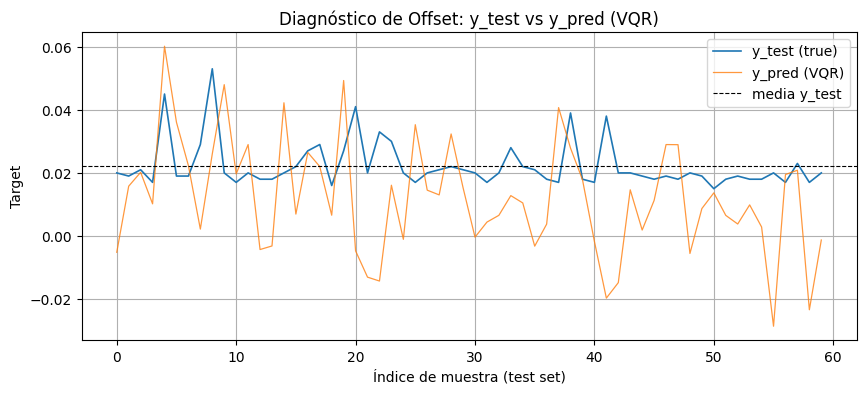


--- Fin del pipeline cuántico ---
Sugerencias:
- Usa menos qubits (3–5) si tarda demasiado.
- Prueba optimizadores como COBYLA o NelderMead si quieres ver la curva de pérdida.
- Mantén reps bajos (1–2) para pruebas rápidas.
- Ejecuta en IBM Quantum Experience para validación real.


In [ ]:
# =============================================
# ⚛️ VQR_pipeline_solo_cuantico.py
# Versión reducida (300 muestras, 8 features, sin Aer)
# =============================================

# ==============================
# 🔧 Imports y configuración
# ==============================
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_machine_learning.algorithms import VQR
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.utils import algorithm_globals

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Semilla reproducible
algorithm_globals.random_seed = 42
np.random.seed(42)

# ==============================
# 🧠 Carga del dataset
# ==============================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
resp = requests.get(url)
lines = [l.strip() for l in resp.text.splitlines()]

attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
data = [r.split(',') for r in rows]

df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric)
df.columns = df.columns.str.strip()
print("Dataset shape:", df.shape)

# ==============================
# 🧹 Filtro LOF (detección de outliers)
# ==============================
candidate_cols = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa',
                  'SaTime4', 'AbsRoll', 'Q', 'ClimbRate']
candidate_cols = [c for c in candidate_cols if c in df.columns]
TARGET = 'Goal'

X_all = df[candidate_cols].astype(float)
y_all = df[TARGET].astype(float)

lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)
mask = lof.fit_predict(X_all) == 1
X_filtered = X_all[mask].reset_index(drop=True)
y_filtered = y_all[mask].reset_index(drop=True)
print("Tras LOF -> filas:", X_filtered.shape[0])

# ==============================
# 🧩 Reducción de tamaño para pruebas
# ==============================
n_samples = 300
if len(X_filtered) > n_samples:
    X_filtered = X_filtered.sample(n=n_samples, random_state=42).reset_index(drop=True)
    y_filtered = y_filtered.loc[X_filtered.index].reset_index(drop=True)
print(f"Usando {len(X_filtered)} muestras para entrenamiento/prueba.")

# ==============================
# ⚙️ Preprocesamiento: log + escalado (-π, π)
# ==============================
selected_features = candidate_cols  # usa las 8 características

X_proc = X_filtered.copy()
for c in selected_features:
    X_proc[c] = np.log1p(np.clip(X_proc[c].values, a_min=0, a_max=None))

scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X_proc[selected_features])

# ==============================
# 🔀 Train/test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_filtered.values, test_size=0.20, random_state=42
)
print("Train / Test shapes:", X_train.shape, X_test.shape)

# ==============================
# ⚛️ Modelo cuántico: VQR (Variational Quantum Regressor)
# ==============================
num_qubits = X_train.shape[1]  # 8 qubits

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
ansatz = RealAmplitudes(num_qubits, reps=2, entanglement="linear")

optimizer = SPSA(maxiter=150)
estimator = StatevectorEstimator()

# Definir callback seguro
loss_history = []
def callback(weights, loss):
    if loss is not None:
        loss_history.append(loss)

vqr = VQR(
    num_qubits=num_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='squared_error',
    optimizer=optimizer,
    estimator=estimator,
    callback=callback
)

# ==============================
# 🚀 Entrenamiento
# ==============================
print("\nEntrenando modelo VQR — esto puede tardar unos minutos...")
vqr.fit(np.asarray(X_train), np.asarray(y_train))
y_pred_vqr = vqr.predict(np.asarray(X_test))

# ==============================
# 📊 Evaluación
# ==============================
mse_vqr = mean_squared_error(y_test, y_pred_vqr)
mae_vqr = mean_absolute_error(y_test, y_pred_vqr)
print(f"\nVQR -> MSE: {mse_vqr:.6e}, MAE: {mae_vqr:.6e}")

# ==============================
# 📈 Visualización
# ==============================
if len(loss_history) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(loss_history, marker='o', color='purple')
    plt.title("Evolución de la pérdida (VQR-SPSA)")
    plt.xlabel("Iteración")
    plt.ylabel("Loss (squared error)")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ No se registraron pérdidas en el callback (SPSA no devuelve loss).")

# Gráfica True vs Pred
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_vqr, color='blue', alpha=0.6, label='VQR (SPSA)')
mn = min(np.min(y_test), np.min(y_pred_vqr))
mx = max(np.max(y_test), np.max(y_pred_vqr))
plt.plot([mn, mx], [mn, mx], 'k--', label='y = x')
plt.title("True vs Predicted (VQR)")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Diagnóstico de offset
plt.figure(figsize=(10,4))
plt.plot(y_test, label='y_test (true)', linewidth=1.2)
plt.plot(y_pred_vqr, label='y_pred (VQR)', linewidth=0.9, alpha=0.8)
plt.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=0.8, label='media y_test')
plt.title("Diagnóstico de Offset: y_test vs y_pred (VQR)")
plt.xlabel("Índice de muestra (test set)")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.show()

# ==============================
# 🧾 Conclusión
# ==============================
print("\n--- Fin del pipeline cuántico ---")
print("Sugerencias:")
print("- Usa menos qubits (3–5) si tarda demasiado.")
print("- Prueba optimizadores como COBYLA o NelderMead si quieres ver la curva de pérdida.")
print("- Mantén reps bajos (1–2) para pruebas rápidas.")
print("- Ejecuta en IBM Quantum Experience para validación real.")
